## Universal Denoiser to Action Potential Recording

### Setup
Use libraries like Elephant or Brian2 to generate realistic spike trains for each neuron.
\
pip install elephant

In [1]:
import numpy as np
import math
from sys import stdout
import numpy as np
import matplotlib.pyplot as plt
import elephant.spike_train_generation as stg
import quantities as pq
import scipy.signal as sig
from scipy.linalg import toeplitz
import dill as pickle
from lz78 import Sequence, LZ78Encoder, CharacterMap, BlockLZ78Encoder, LZ78SPA
from lz78 import encoded_sequence_from_bytes, spa_from_bytes


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


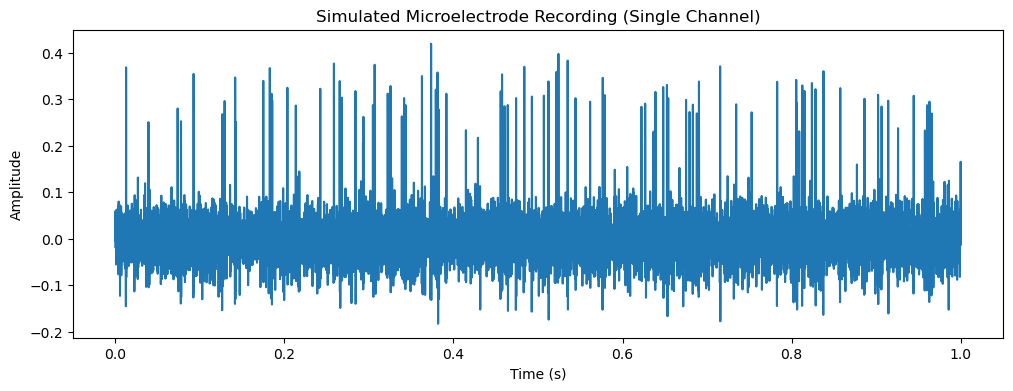

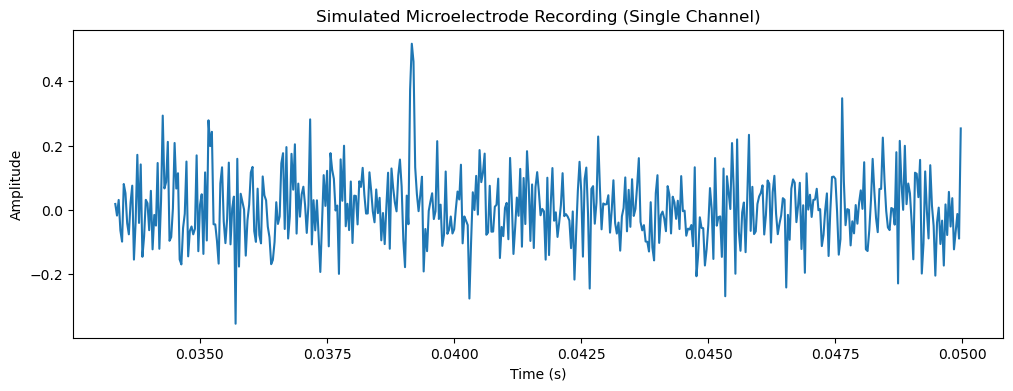

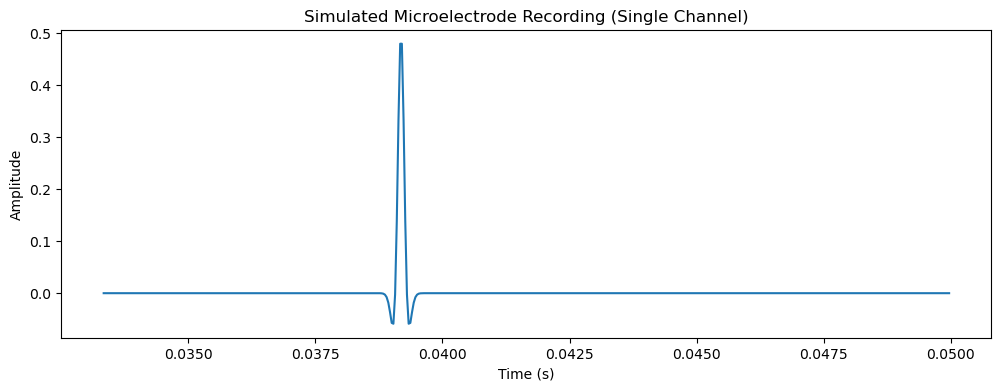

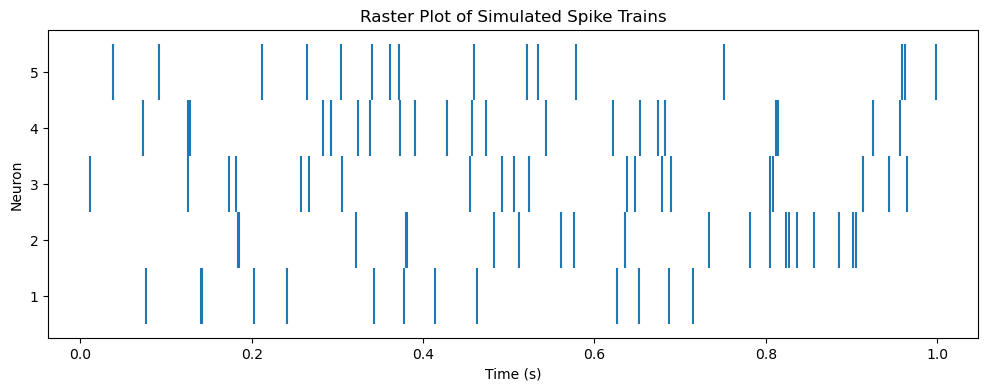

In [2]:
# Generate Action Potential Spike Trains
# Parameters
sampling_rate = 30000  # 30 kHz
duration = 1.0  # 1 second
n_neurons = 5  # Number of neurons contributing
spike_rates = np.random.uniform(5, 20, n_neurons)  # Random rates (5-20 Hz)
noise_level = 0.1  # Noise amplitude
t = np.linspace(0, duration, int(sampling_rate * duration))  # Time vector

# Generate spike trains for each neuron
spike_trains = []
for rate in spike_rates:
    spike_train = stg.homogeneous_poisson_process(rate * pq.Hz, t_stop=duration * pq.s)
    spike_trains.append(spike_train)

# Create action potential waveform (2 ms duration, 30 kHz sampling)
spike_duration = int(0.002 * sampling_rate)  # 2 ms
time = np.linspace(-1, 1, spike_duration)
spike_waveform = np.exp(-time**2 / 0.01) - 0.5 * np.exp(-time**2 / 0.02) # Replace with EI waveforms

# Combine spike trains into a composite signal
signal = np.zeros(len(t))
noisy_signal = np.zeros(len(t))
for spike_train in spike_trains:
    for spike_time in spike_train:
        idx = int(spike_time.rescale('s').magnitude * sampling_rate)
        if idx + spike_duration < len(signal):
            signal[idx:idx + spike_duration] += spike_waveform

# Add Gaussian noise
clean_signal = signal.copy()
signal += noise_level * np.random.normal(size=len(signal))

# Band-pass filter (300-3000 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sig.butter(order, [low, high], btype="band")
    return sig.filtfilt(b, a, data)
filtered_clean_signal = bandpass_filter(clean_signal, 300, 3000, sampling_rate)
filtered_signal = bandpass_filter(signal, 300, 3000, sampling_rate)

# Plot the signal
plt.figure(figsize=(12, 4))
plt.plot(t, filtered_signal)
plt.title("Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot zoomed-in view
plt.figure(figsize=(12, 4))
plt.plot(t[1000:1500], signal[1000:1500])
plt.title("Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot the clean signal
plt.figure(figsize=(12, 4))
plt.plot(t[1000:1500], clean_signal[1000:1500])
plt.title("Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


# Raster plot for spike trains
plt.figure(figsize=(12, 4))
for i, spike_train in enumerate(spike_trains):
    plt.vlines(spike_train, i + 0.5, i + 1.5)
plt.title("Raster Plot of Simulated Spike Trains")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
plt.show()



In [3]:
## Import real action potential data from file and get the EIs as real templates
import bin2py
import visionloader as vl

L_SAMPLES = 20
R_SAMPLES = 40
start= 1000
nS = 2400000 -  start
datarun = 'data000'
num_samples = L_SAMPLES + R_SAMPLES + 1
x = range(61)

comp_data_path_1 = "/data/home/pumiaoy/DATA/2018-08-07-5/naive_2ramp/2Proj/12b_8w/data000"
comp_data_path_2 = "/data/home/pumiaoy/DATA/2018-08-07-5/naive_2ramp/2Proj/10b_8w/data000"
raw_data_path_1 = "/data/home/pumiaoy/DATA/2018-08-07-5/data000"
analysis_path_1 ="/data/home/pumiaoy/Analysis/2018-08-07-5/kilosort_data000/data000"

## Load Data
vision_data = vl.load_vision_data(analysis_path_1,
                                  datarun,
                                  include_params=True,
                                  include_ei=True,
                                  #include_sta=True, 
                                  #include_runtimemovie_params=True,
                                  include_neurons=True,
                                  include_noise=True)
elec_loc = vision_data.get_electrode_map()
# get EI for electrode
def get_EI_for_electrode(elec, vision_data, threshold ):
    cell_list = vision_data.get_cell_ids()
    ei_templates = []
    for cellid in cell_list:
        celltype = vision_data.get_cell_type_for_cell(cellid).lower()
        #print(celltype)
        if ('midget' or 'parasol') not in celltype:
            #break
            continue
        ei_for_cell = vision_data.get_ei_for_cell(cellid).ei
        ei_amplitude = np.max(np.abs(ei_for_cell[elec,:]))
        if ei_amplitude > threshold:
            ei_templates.append(ei_for_cell[elec,:])
    return ei_templates
electrode = 500
thresh = 30
EI_templates = get_EI_for_electrode(electrode, vision_data, thresh)
print(len(EI_templates))
print(EI_templates[0].shape)        

3
(61,)


3


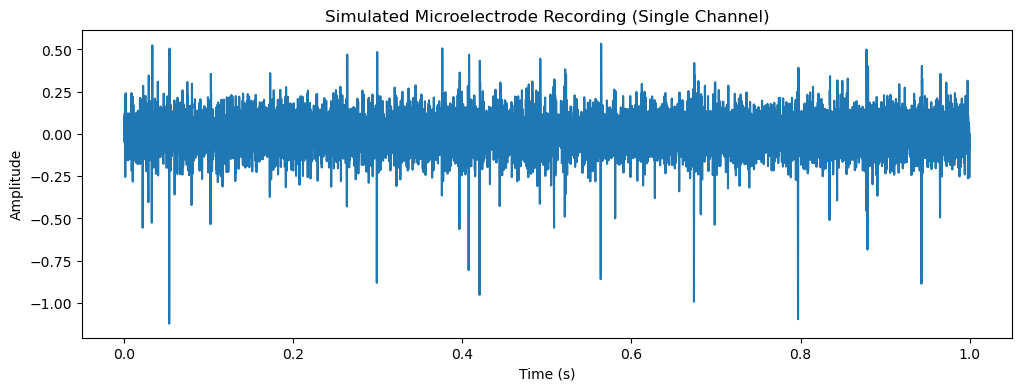

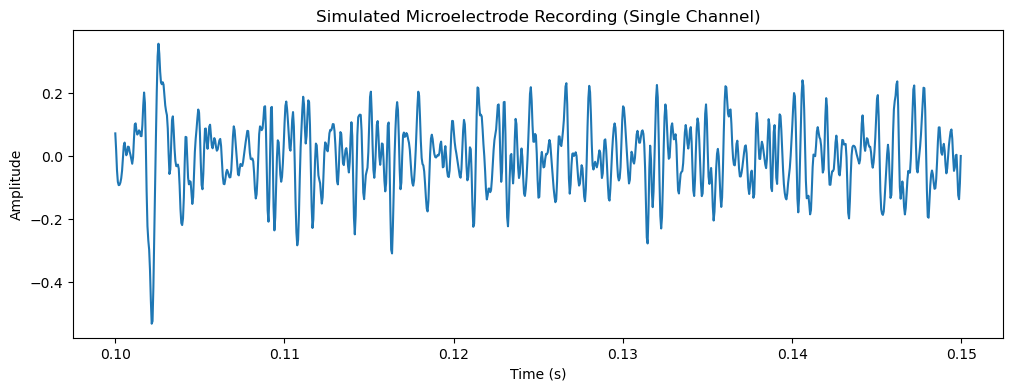

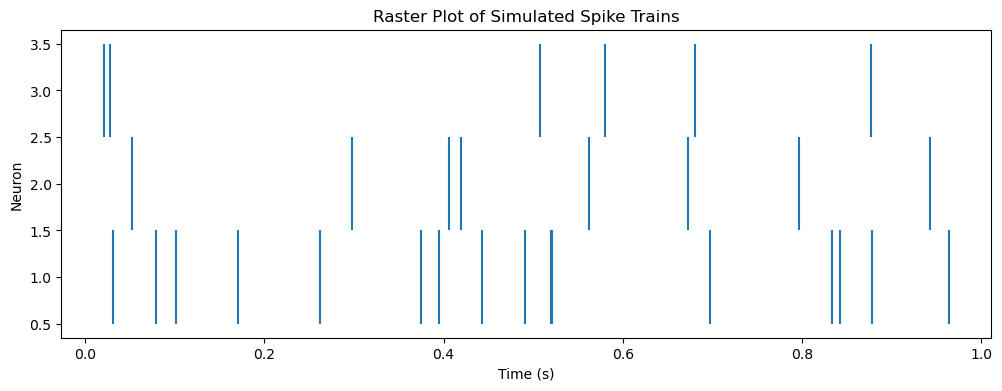

In [4]:
n_neurons = len(EI_templates) # Number of neurons
sampling_rate = 20_000  # 20 kHz
scaling_factors = np.random.uniform(0.5, 1.5, n_neurons)  # Random amplitude scaling
delays = np.random.uniform(-0.0002, 0.0002, n_neurons)  # Random delays (-200 to +200 µs)
duration = 1.0  # 1 second
# Ensure delays are within range of signal length
max_delay = int(np.max(np.abs(delays)) * sampling_rate)
spike_rates = np.random.uniform(5, 20, n_neurons)  # Random rates (5-20 Hz)

noise_level = 0.2  # Noise amplitude
t = np.linspace(0, duration, int(sampling_rate * duration))  # Time vector

# Generate spike trains for each neuron
spike_trains = []
for rate in spike_rates:
    spike_train = stg.homogeneous_poisson_process(rate * pq.Hz, t_stop=duration * pq.s)
    spike_trains.append(spike_train)
print(len(spike_trains))

## Add spike waveforms
real_spike_waveform = EI_templates
# Normalize amplitude (optional)
normalized_spike_waveform = real_spike_waveform / np.max(np.abs(real_spike_waveform))

# Generate composite signal with amplitude scaling and delays
signal = np.zeros(int(duration * sampling_rate))
for i, spike_train in enumerate(spike_trains):
    
    for spike_time in spike_train:
        # Adjust spike time by delay
        delayed_time = spike_time.rescale('s').magnitude + delays[i]
        idx = int(delayed_time * sampling_rate)
        
        # Check bounds and embed the scaled waveform
        if 0 <= idx < len(signal) - len(real_spike_waveform):
            scaled_waveform = scaling_factors[i] * normalized_spike_waveform[i]
            signal[idx:idx + len(scaled_waveform)] += scaled_waveform

# Add Gaussian noise
signal += noise_level * np.random.normal(size=len(signal))


# Band-pass filter (300-3000 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sig.butter(order, [low, high], btype="band")
    return sig.filtfilt(b, a, data)

filtered_signal = bandpass_filter(signal, 300, 3000, sampling_rate)

# Plot the signal
plt.figure(figsize=(12, 4))
plt.plot(t, filtered_signal)
plt.title("Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot zoomed-in view
plt.figure(figsize=(12, 4))
plt.plot(t[2000:3000], filtered_signal[2000:3000])
plt.title("Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Raster plot for spike trains
plt.figure(figsize=(12, 4))
for i, spike_train in enumerate(spike_trains):
    plt.vlines(spike_train, i + 0.5, i + 1.5)
plt.title("Raster Plot of Simulated Spike Trains")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
plt.show()


### Quantize Noisy Data


Quantization Resolution:  3


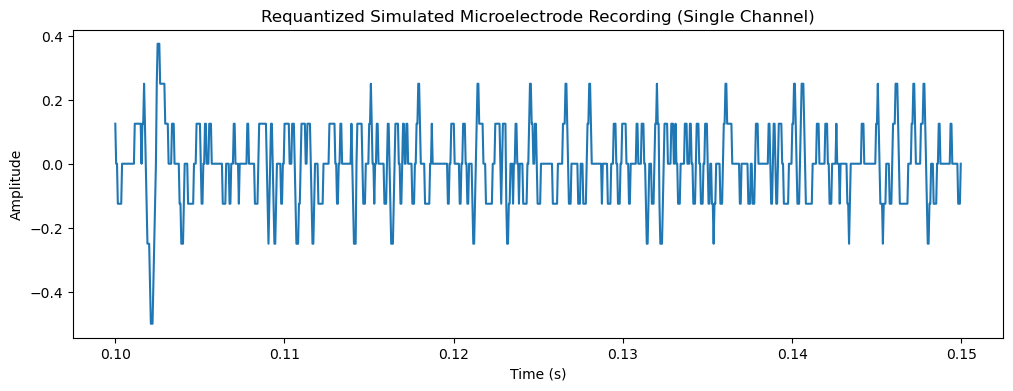

In [5]:
V_pp = np.max(filtered_signal) - np.min(filtered_signal)
SNR= V_pp/noise_level
Q_opt = int(math.log2(SNR))
q_steps = 2**Q_opt
#requantize the signal
def requantize(signal, q_steps):
    q_signal = np.round(signal*q_steps)/q_steps
    return q_signal
q_signal = requantize(filtered_signal, q_steps)
# Plot the signal
plt.figure(figsize=(12, 4))
plt.plot(t[2000:3000], q_signal[2000:3000])
plt.title("Requantized Simulated Microelectrode Recording (Single Channel)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
print("Quantization Resolution: ", Q_opt)

In [6]:
# spa training data
n_neurons = len(EI_templates) # Number of neurons
sampling_rate = 20_000  # 20 kHz
scaling_factors = np.random.uniform(0.5, 1.5, n_neurons)  # Random amplitude scaling
delays = np.random.uniform(-0.0002, 0.0002, n_neurons)  # Random delays (-200 to +200 µs)
duration = 360  # 1 second
# Ensure delays are within range of signal length
max_delay = int(np.max(np.abs(delays)) * sampling_rate)
spike_rates = np.random.uniform(5, 20, n_neurons)  # Random rates (5-20 Hz)

noise_level = 0.1  # Noise amplitude
t = np.linspace(0, duration, int(sampling_rate * duration))  # Time vector

# Generate spike trains for each neuron
spike_trains = []
for rate in spike_rates:
    spike_train = stg.homogeneous_poisson_process(rate * pq.Hz, t_stop=duration * pq.s)
    spike_trains.append(spike_train)
print(len(spike_trains))

## Add spike waveforms
real_spike_waveform = EI_templates
# Normalize amplitude (optional)
normalized_spike_waveform = real_spike_waveform / np.max(np.abs(real_spike_waveform))

# Generate composite signal with amplitude scaling and delays
signal = np.zeros(int(duration * sampling_rate))
for i, spike_train in enumerate(spike_trains):
    
    for spike_time in spike_train:
        # Adjust spike time by delay
        delayed_time = spike_time.rescale('s').magnitude + delays[i]
        idx = int(delayed_time * sampling_rate)
        
        # Check bounds and embed the scaled waveform
        if 0 <= idx < len(signal) - len(real_spike_waveform):
            scaled_waveform = scaling_factors[i] * normalized_spike_waveform[i]
            signal[idx:idx + len(scaled_waveform)] += scaled_waveform

# Add Gaussian noise
clean_signal = signal.copy()
signal += noise_level * np.random.normal(size=len(signal))

filtered_clean_signal = bandpass_filter(clean_signal, 300, 3000, sampling_rate)
filtered_signal = bandpass_filter(signal, 300, 3000, sampling_rate)

3


In [7]:
def requantize_ind(signal, q_steps):
    q_signal = np.round(signal*q_steps)/q_steps
    floor = np.min(q_signal)
    lsb = (np.max(q_signal) - floor) / (q_steps - 1)
    # convert to the index of the quantization step
    q_index = np.round((q_signal - floor)/lsb).astype(int)
    return q_index

In [8]:
noisy_signal_quantized = requantize_ind(signal, q_steps)

In [ ]:
#sdtout.flush() ## add for any long process
ap_spa = LZ78SPA(q_steps, gamma=0.5)
signal_str = ''.join([str(i) for i in noisy_signal_quantized])
char_map =  CharacterMap(signal_str)
# encode decode
input = Sequence( signal_str, charmap= char_map)
train_loss = ap_spa.train_on_block(input) / (duration * sampling_rate)